# Calculating band indices with Spyndex packages

* **Products used:** 
[ s2_l2a](https://explorer.digitalearth.africa/s2_l2a) 

## Background

The [Spyndex python package](https://www.nature.com/articles/s41597-023-02096-0) provides access to spectral indices from the Awesome Spectral Indices catalogue which is a standardized ready to use curated list of spectral indices. The Spyndex package has a total of [232 optical and radar indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices/blob/main/output/spectral-indices-table.csv) available currently.

One of the benefits of this package is the large number of spectral indices available to the sandbox users for analysis without having to manually add to the notebooks.

## Description
This notebook demonstrates how to:
 
* Load dataset using `load_ard`
* Calculate NDVI and EVI indices using the `spyndex` function 
* Calculate NDVI and EVI indices using the `calculate_indices` function
* Plot the results from both functions

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Addition to the exsiting pacakges,the spyndex package will be loaded by importing it.

In [1]:
# Load the python packages.
%matplotlib inline

import os

os.environ["USE_PYGEOS"] = "0"

import matplotlib.pyplot as plt
import geopandas as gpd

#Import spyndex packages
import spyndex

import datacube


from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb
from deafrica_tools.bandindices import calculate_indices
from datacube.utils.geometry import Geometry
from deafrica_tools.areaofinterest import define_area

### Connect to the datacube
Connect to the datacube database to enable loading Digital Earth Africa data.

In [2]:
# Connect to the datacube
dc = datacube.Datacube(app="spyndex_function")

### Select location
Using the `define_area` function, select area of interest by specifying `lat`,`lon` and `buffer`. If you have the vector or shapefile uncomment the code below **Method 2** and replace the `aoi.shp` with the path of your  shapefile.

In [3]:
# Method 1: Specify the latitude, longitude, and buffer
aoi = define_area(lat=13.94, lon=-16.54, buffer=0.125)

# Method 2: Use a polygon as a GeoJSON or Esri Shapefile. 
#aoi = define_area(shapefile_path='aoi.shp')

#Create a geopolygon and geodataframe of the area of interest
geopolygon = Geometry(aoi["features"][0]["geometry"], crs="epsg:4326")
geopolygon_gdf = gpd.GeoDataFrame(geometry=[geopolygon], crs=geopolygon.crs)

# Get the latitude and longitude range of the geopolygon
lat_range = (geopolygon_gdf.total_bounds[1], geopolygon_gdf.total_bounds[3])
lon_range = (geopolygon_gdf.total_bounds[0], geopolygon_gdf.total_bounds[2])

### Create a query and load satellite data

To demonstrate how to compute a remote sensing index, we first need to load time series of satellite data for an area. Sentinel-2 satellite data will be used:

It is highly recommended to load data with `load_ard` when calculating indices. This is because `load_ard` performs the necessary data cleaning and scaling for more robust index results. Refer to [Using_load_ard](../Frequently_used_code/Using_load_ard.ipynb) to learn more

In [4]:
# time_range.
time_range = ("2019-06", "2020-06")


# Create a reusable query object.
query = {
    "x": lon_range, 
    "y": lat_range, 
    "time": time_range, 
    "resolution": (-10, 10)
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product="s2_l2a", query=query)

# Load available data from Sentinel-2 and filter to retain only times
# with at least 99% good data
ds = load_ard(
    dc=dc,
    products=["s2_l2a"],
    min_gooddata=0.99,
    measurements=["red", "green", "blue", "nir"],
    output_crs=output_crs,
    **query
)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 4 out of 78 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Loading 4 time steps


#### Print the xarray dataset

In [5]:
print(ds)

<xarray.Dataset>
Dimensions:      (time: 4, y: 2784, x: 2721)
Coordinates:
  * time         (time) datetime64[ns] 2019-10-20T11:47:38 ... 2020-03-18T11:...
  * y            (y) float64 1.556e+06 1.556e+06 ... 1.528e+06 1.528e+06
  * x            (x) float64 3.2e+05 3.2e+05 3.2e+05 ... 3.472e+05 3.472e+05
    spatial_ref  int32 32628
Data variables:
    red          (time, y, x) float32 1.918e+03 2.182e+03 ... 1.962e+03
    green        (time, y, x) float32 1.588e+03 1.834e+03 ... 1.324e+03
    blue         (time, y, x) float32 856.0 971.0 475.0 ... 974.0 951.0 942.0
    nir          (time, y, x) float32 4.002e+03 4.192e+03 ... 2.998e+03
Attributes:
    crs:           EPSG:32628
    grid_mapping:  spatial_ref


### Plot the images to see how our area looks like
The `rgb` function is used to plot the timesteps in our dataset as true colour RGB images:

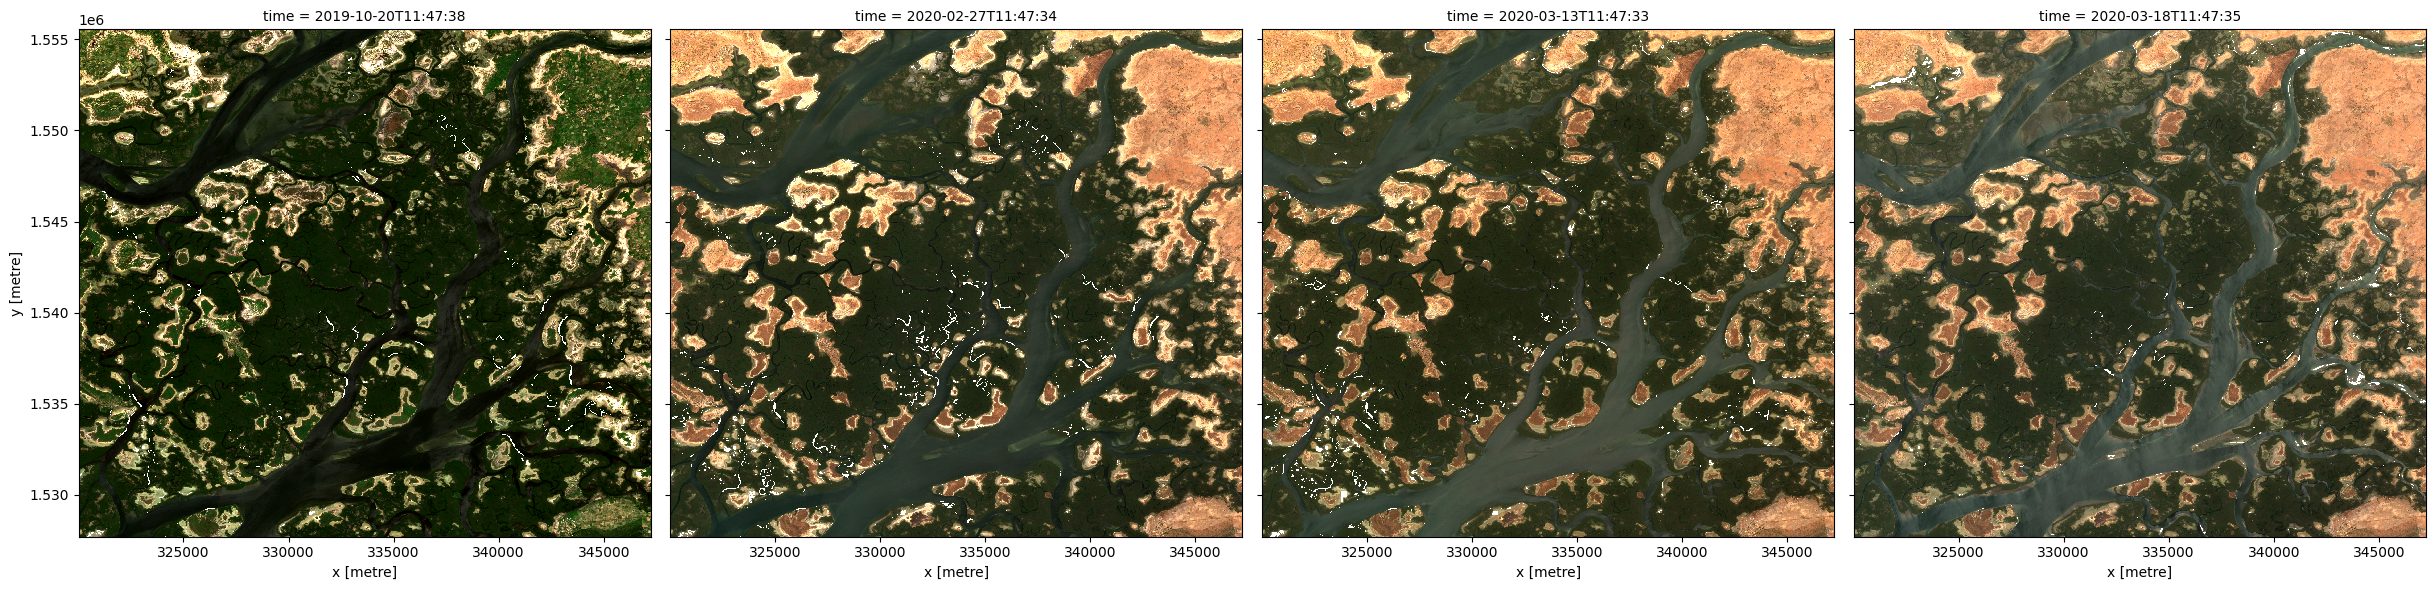

In [6]:
rgb(ds, col="time")

### Calculate NDVI using spyndex
Spyndex Packages comes with [232 indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices/blob/main/output/spectral-indices-table.csv). For this notebook, 2 indices will be used as an example
`NDVI` and `EVI`.

#### Printout the NDVI Index attributes. 
Using `spyndex.indices[indexName]` gives the detail parameter of the Spectral Index being used.
The cell below print out the information concerning `NDVI` Spectral Index.

In [7]:
print(spyndex.indices["EVI"])

EVI: Enhanced Vegetation Index
        * Application Domain: vegetation
        * Bands/Parameters: ['g', 'N', 'R', 'C1', 'C2', 'B', 'L']
        * Formula: g*(N-R)/(N+C1*R-C2*B+L)
        * Reference: https://doi.org/10.1016/S0034-4257(96)00112-5
        


#### Compute the NDVI index using the `spectral computeIndex` method.

The cell below shows how spyndex computes the spectral indeices using `spectral computeindex` function.
The `spectral computeindex function` takes the 
*  `index` argument and it specify the spectral indices that is to be calculated
* `params` argument takes the bands from the DE Africa dataset and its corresponding formula name shown in the `print(spyndex.indices["NDVI"])` above. `NDVI` takes the `N` and `R` from the formula and it's corresponding bands in DE Africa dataset are `ds.nir` and `ds.red`.

In [8]:
ds["NDVI_spyndex"] = spyndex.computeIndex(
    index=["NDVI"], 
    params={
        "N": ds.nir, 
        "R": ds.red
    }
)

#### Compute NDVI using the `calculate indices` function.
Using DE Africa `calculate_indices` to calculate the NDVI spectral index. More information [here](../Frequently_used_code/Calculating_band_indices.ipynb)

In [9]:
ds = calculate_indices(ds, index="NDVI", satellite_mission="s2")

#### Plot the NDVI results.

The comparison plot below shows that NDVI from calculate_indices matches values calculated using the Spyndex package.

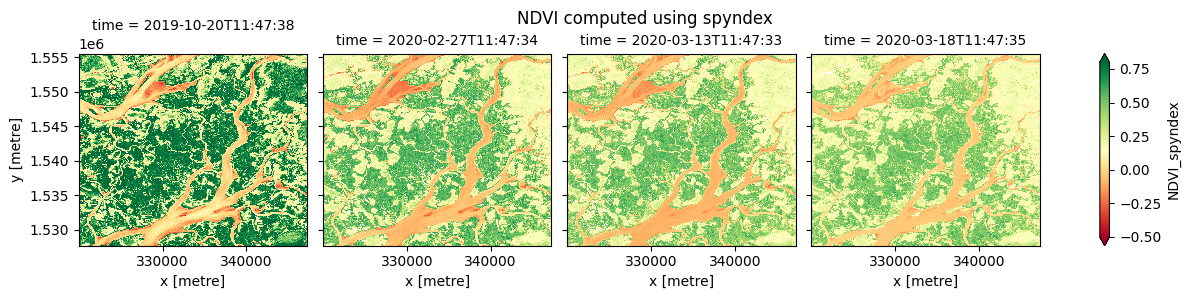

In [ ]:
fig_1 = ds.NDVI_spyndex.plot(col="time", vmin=-0.50, vmax=0.8, cmap="RdYlGn")
fig_1.fig.suptitle("NDVI computed using spyndex")

fig_2 = ds.NDVI.plot(col="time", vmin=-0.50, vmax=0.8, cmap="RdYlGn")
fig_2.fig.suptitle("NDVI computed using calculate_indices")

plt.show()

#### Calculate  Normalized Difference Water Index (NDWI) using spyndex

Using `spyndex.indices[indexName]` gives the detail parameter of the Spectral Index being used.
The cell below print out the information concerning `NDWI` Spectral Index.

In [ ]:
    print(spyndex.indices["NDWI"])

#### Compute the NDWI index using the `spectral computeIndex` method.

From the above indices `NDWI` has constant values for its computation. 


Spyndex fucntion provides the constant values which can also be overwritten. The [constants](https://github.com/awesome-spectral-indices/awesome-spectral-indices/blob/main/output/constants.json) can be accessed using `spyndex.constants` as shown below.

In [ ]:
ds["NDWI_spindex"] = spyndex.computeIndex(
    index=["NDWI"],
    params={
        "N": ds.nir,
        "G": ds.green,
    },
)

#### Compute EVI using the `calculate indices` function.
Using DE Africa `calculate_indices` to calculate the NDWI spectral index.

In [ ]:
ds = calculate_indices(ds, index=["NDWI"], satellite_mission="s2")

#### Plot the EVI results.
The comparison plot below shows that NDWI from calculate_indices matches values calculated using the Spyndex package.

In [ ]:
fig_4 = ds.NDWI.plot(col="time", cmap="Blues")
fig_4.fig.suptitle("NDWI computed using calculate_indices")

fig_5 = ds.NDWI_spindex.plot(col="time", cmap="Blues")
fig_5.fig.suptitle("NDWI computed using spyndex");

plt.show()

#### Conclusion

The notebook show how `Spyndex function` can be used with DE Africa dataset to compute Spectral Indices.There are [232 optical and radar indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices/blob/main/output/spectral-indices-table.csv) available, why not try it out and modified the notebook to test the results.

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import date
print(date.today())